<a href="https://colab.research.google.com/github/siman-giri/Machine_learning_LABS/blob/master/Clustering_FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
class Data_processing:
    def __init__(self, dataset, normalize =True):
        import numpy as np
        self.dataset = dataset
        self.read_data()
        self.normalize = normalize
        if self.normalize == True:
            self.normalization()
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        self.Y = self.change_label(self.Y)

    def read_data(self):
        import pandas as pd
        self.data = pd.read_csv(self.dataset)
        self.data = self.data.dropna(how='any', axis=1)
        self.remove_single_feature()
        self.X = self.data.iloc[:, :-1]
        self.Y = self.data.iloc[:, -1]

    def remove_single_feature(self):
        for col in self.data.columns:
            if len(self.data[col].unique()) == 1:
                self.data.drop(col,inplace=True,axis=1)

    def change_label(self, data):
        # change descriptive label to numerical value
        import numpy as np
        current_number = 0
        y_train_dictionary = {}
        new_y_train = []
        for label in data:
            if label in y_train_dictionary:
                new_y_train.append(y_train_dictionary[label])
            else:
                y_train_dictionary[label] = current_number
                new_y_train.append(y_train_dictionary[label])
                current_number += 1
        return np.array(new_y_train)

    def normalization(self):
        normalizer = lambda x: x - x.mean() / x.std()
        self.X = self.X.apply(normalizer, axis=0)


In [0]:
class PCA():
    """A method for doing dimensionality reduction by transforming the feature
    space to a lower dimensionality, removing correlation between features and
    maximizing the variance along each feature axis. This class is also used throughout
    the project to plot data.
    """
    def calculate_covariance_matrix(self,X, Y=None):
            import numpy as np
            """ Calculate the covariance matrix for the dataset X """
            if Y is None:
                Y = X
            n_samples = np.shape(X)[0]
            covariance_matrix = (1 / (n_samples - 1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

            return np.array(covariance_matrix, dtype=float)

    def transform(self, X, n_components):
        import numpy as np
        """ Fit the dataset to the number of principal components specified in the
        constructor and return the transformed dataset """
        covariance_matrix = self.calculate_covariance_matrix(X)

        # Where (eigenvector[:,0] corresponds to eigenvalue[0])
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # Sort the eigenvalues and corresponding eigenvectors from largest
        # to smallest eigenvalue and select the first n_components
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:n_components]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :n_components]

        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed

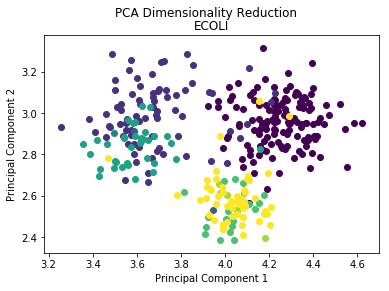

In [0]:
def main():
    import matplotlib.pyplot as plt
    import matplotlib.cm as cmx
    import matplotlib.colors as colors
    import numpy as np

    # Demo of how to reduce the dimensionality of the data to two dimension
    # and plot the results. 

    # Load the dataset
     # Load the dataset
    data = Data_processing(filename)
    X = data.X
    #print(X)
    y = data.Y
    #print(y)


  # Pr oject the data onto the 2 primary principal components
    X_trans = PCA().transform(X, 2)
    #print(X_trans)

    x1 = X_trans[:, 0]
    x2 = X_trans[:, 1]

    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

    class_distr = []
    # Plot the different class distributions
    for i, l in enumerate(np.unique(y)):
        _x1 = x1[y == l]
        _x2 = x2[y == l]
        _y = y[y == l]
        class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

    # Add a legend
   # plt.legend(class_distr, y_changed, loc=1)

    # Axis labels
    plt.suptitle("PCA Dimensionality Reduction")
    plt.title("ECOLI")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


if __name__ == "__main__":
    main()

In [0]:
from __future__ import print_function, division
import numpy as np

class KMeans():

    def __init__(self, k=3, max_iterations=500):
        self.k = k
        self.max_iterations = max_iterations

    def euclidean_distance(self, point1, point2):
        import math
        """ Calculates the l2 distance between two vectors """
        distance = 0
        # Squared distance between each coordinate
        for i in range(len(point1)):
            distance += pow((point1[i] - point2[i]), 2)
        return math.sqrt(distance)

    def _init_random_centroids(self, X):
        """ Initialize the centroids as k random samples of X"""
        n_samples, n_features = np.shape(X)
        centroids = np.zeros((self.k, n_features))
        for i in range(self.k):
            centroid = X[np.random.choice(range(n_samples))]
            centroids[i] = centroid
        return centroids

    def _closest_centroid(self, sample, centroids):
        """ Return the index of the closest centroid to the sample """
        closest_i = 0
        closest_dist = float('inf')
        for i, centroid in enumerate(centroids):
            distance = self.euclidean_distance(sample, centroid)
            if distance < closest_dist:
                closest_i = i
                closest_dist = distance
        return closest_i

    def _create_clusters(self, centroids, X):
        """ Assign the samples to the closest centroids to create clusters """
        n_samples = np.shape(X)[0]
        clusters = [[] for _ in range(self.k)]
        for sample_i, sample in enumerate(X):
            centroid_i = self._closest_centroid(sample, centroids)
            clusters[centroid_i].append(sample_i)
        return clusters

    def _calculate_centroids(self, clusters, X):
        """ Calculate new centroids as the means of the samples in each cluster  """
        n_features = np.shape(X)[1]
        centroids = np.zeros((self.k, n_features))
        for i, cluster in enumerate(clusters):
            centroid = np.mean(X[cluster], axis=0)
            centroids[i] = centroid
        return centroids

    def _get_cluster_labels(self, clusters, X):
        """ Classify samples as the index of their clusters """
        # One prediction for each sample
        y_pred = np.zeros(np.shape(X)[0])
        for cluster_i, cluster in enumerate(clusters):
            for sample_i in cluster:
                y_pred[sample_i] = cluster_i
        return y_pred

    def predict(self, X):
        """ Do K-Means clustering and return cluster indices """

        # Initialize centroids as k random samples from X
        centroids = self._init_random_centroids(X)

        # Iterate until convergence or for max iterations
        for _ in range(self.max_iterations):
            # Assign samples to closest centroids (create clusters)
            clusters = self._create_clusters(centroids, X)
            # Save current centroids for convergence check
            prev_centroids = centroids
            # Calculate new centroids from the clusters
            centroids = self._calculate_centroids(clusters, X)
            # If no centroids have changed => convergence
            diff = centroids - prev_centroids
            if not diff.any():
                break

        return self._get_cluster_labels(clusters, X)




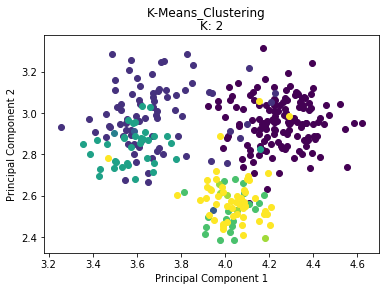

2
[4.08707182 2.62685355]


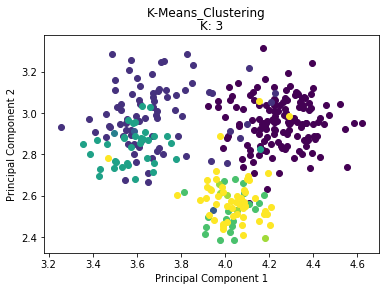

3
[4.28507034 2.95535303]


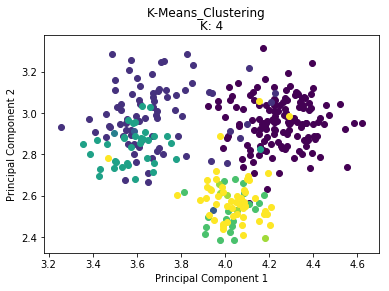

4
[3.49651666 2.73278727]


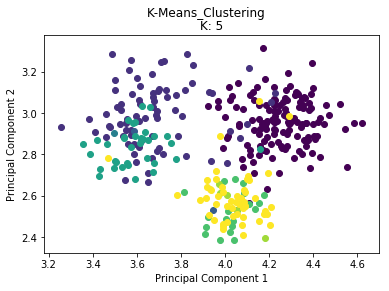

5
[4.37764708 2.87198797]


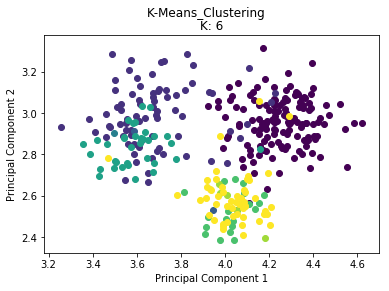

6
[3.68947468 2.81808587]


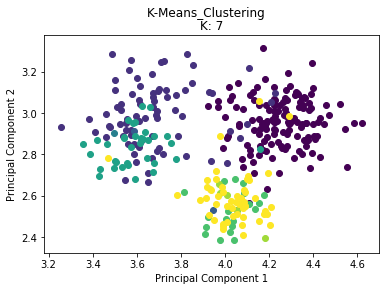

7
[4.3808687  3.04891744]


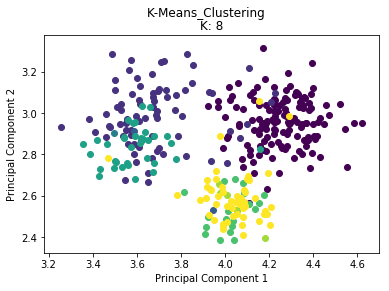

8
[3.255681   2.93318943]


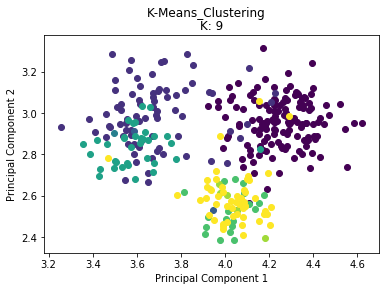

9
[4.28970492 2.94820166]


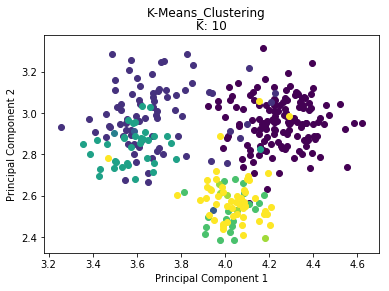

10
[3.72220629 3.25023971]


In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

data = Data_processing(filename)
X = data.X
#print(X)
y = data.Y
#print(y)
X_trans = PCA().transform(X, 2)

def mean_error():
    mean = 0
    centroid = clf._init_random_centroids(X_trans)
    print(len(centroid))
    first_centroid = centroid[0]
    print(first_centroid)
    for i in range(1, len(centroid)):
        mean += np.mean((first_centroid - centroid[i]) ** 2)
    return mean / len(centroid)


mean_metric = []
for k in range(2, 11):
    clf = KMeans(k = k)
    y_pred = clf.predict(X_trans)
    x1 = X_trans[:, 0]
    x2 = X_trans[:, 1]

    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

    class_distr = []
    # Plot the different class distributions
    for i, l in enumerate(np.unique(y)):
        _x1 = x1[y == l]
        _x2 = x2[y == l]
        _y = y_pred[y_pred == l]
        class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

    # Add a legend
    #plt.legend(class_distr, y_pred, loc=1)

      # Axis labels
    plt.suptitle("K-Means_Clustering")
    
    title = 'K: {}'.format(k)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    mean_metric.append(mean_error())



In [0]:
mean_metric

[0.12920787825085903,
 0.1693479395217539,
 0.12226866369113383,
 0.14792835167725288,
 0.1537037094290227,
 0.089074407898954,
 0.1431003923645824,
 0.1630866094465209,
 0.17753902291830448]

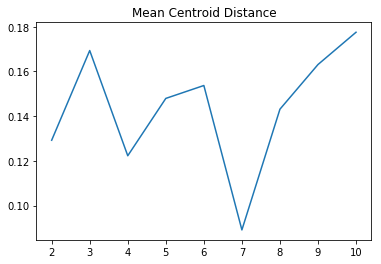

In [0]:
plt.title('Mean Centroid Distance')
x_axis = np.linspace(2,10,9)
plt.plot(x_axis,mean_metric)
plt.show()
